# D214 - Data Analytics Graduate Capstone - Performance Assessment Task 2
## Joshua T. Funderburk

#### Import Libraries & Packages

In [1]:
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor

#### Initial Data Loading and Filtering

In [2]:
df = pd.read_csv(r'C:\Users\funde\Desktop\WGU\D214\HousingUnitInventory.csv', index_col=0, low_memory=False)

In [3]:
df.head()

,UNIT_ID,TYPE,SUBTYPE,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY,COUNTY,SUBCOUNTY,EVAL_DATE,Shape__Area,Shape__Length
OBJECTID,,,,,,,,,,,,,,,,,
1,0,single_family,single_family,1.0,11,1.282095,8.579707,18703.0,8678200.0,2000.0,2000.0,Springdale,Washington,NaN,1/22/2024 12:00:00 PM,5.480510e+04,1876.450253
2,1,single_family,single_family,1.0,9,0.377838,23.819754,14931.0,5327500.0,2019.0,2010.0,Springdale,Washington,NaN,1/22/2024 12:00:00 PM,1.520613e+05,1793.792754
3,2,single_family,single_family,1.0,77,0.285765,269.452534,104143.0,38757200.0,2020.0,2020.0,Springdale,Washington,NaN,1/22/2024 12:00:00 PM,1.720329e+06,16241.656591
4,3,single_family,townhome,1.0,20,5.276712,3.790239,28991.0,15922500.0,2014.0,2010.0,Springdale,Washington,NaN,1/22/2024 12:00:00 PM,2.421229e+04,842.041499
5,4,single_family,single_family,1.0,35,4.769242,7.338692,66824.0,15567700.0,2005.0,2000.0,La Verkin,Washington,NaN,1/22/2024 12:00:00 PM,4.690233e+04,2178.451048


In [4]:
# Drop non-single family rows
df = df[df['TYPE'] == 'single_family']
df['TYPE'].value_counts()

TYPE
single_family    627126
Name: count, dtype: int64

#### Data Cleaning

In [5]:
# Drop specified columns
columns_to_drop = ['TYPE', 'UNIT_ID', 'SUBCOUNTY', 'EVAL_DATE', 'Shape__Area', 'Shape__Length']
df = df.drop(columns=columns_to_drop)

In [6]:
# Drop null values from the dataframe
df.dropna(inplace=True)
df.isnull().sum()

SUBTYPE       0
IS_OUG        0
UNIT_COUNT    0
DUA           0
ACRES         0
TOT_BD_FT2    0
TOT_VALUE     0
APX_BLT_YR    0
BLT_DECADE    0
CITY          0
COUNTY        0
dtype: int64

In [7]:
# Drop columns where total value is equal to 0
df = df[df['TOT_VALUE'] != 0]

# Drop columns where acres is equal to 0
df = df[df['ACRES'] != 0]

# Drop columns where total building square footage is equal to 0
df = df[df['TOT_BD_FT2'] != 0]

In [8]:
df = df.reset_index(drop=True)

In [9]:
# Identify columns that do not contain values for all rows in the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558696 entries, 0 to 558695
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SUBTYPE     558696 non-null  object 
 1   IS_OUG      558696 non-null  float64
 2   UNIT_COUNT  558696 non-null  int64  
 3   DUA         558696 non-null  float64
 4   ACRES       558696 non-null  float64
 5   TOT_BD_FT2  558696 non-null  float64
 6   TOT_VALUE   558696 non-null  float64
 7   APX_BLT_YR  558696 non-null  float64
 8   BLT_DECADE  558696 non-null  float64
 9   CITY        558696 non-null  object 
 10  COUNTY      558696 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 46.9+ MB


#### Summary Statistics & Visualizing the Data

#### Total Value

- Min: 1
- Max: 1,233,090,900
- Mean: 612,556
- Median: 508,999

In [10]:
# Total Value - Dependent Variable
print("Total Value Summary Statistics:")
df.TOT_VALUE.describe()

Total Value Summary Statistics:


count    5.586960e+05
mean     6.125558e+05
std      2.042048e+06
min      1.000000e+00
25%      4.110000e+05
50%      5.089998e+05
75%      6.550000e+05
max      1.233091e+09
Name: TOT_VALUE, dtype: float64

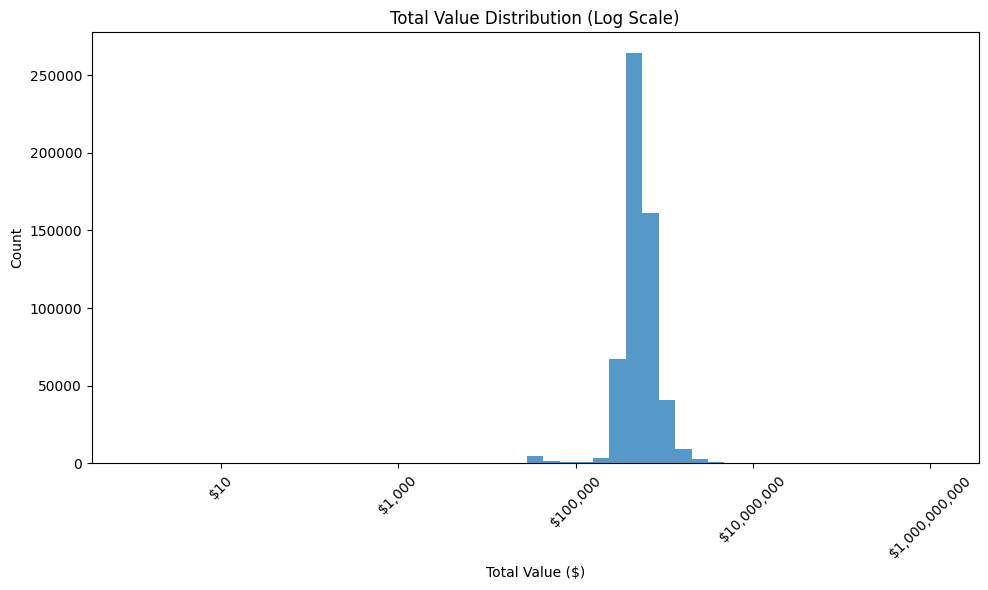

In [11]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate min and max
min_value = df.TOT_VALUE.min()
max_value = df.TOT_VALUE.max()

# Create bins with logarithmic spacing
bins = np.logspace(np.log10(min_value), np.log10(max_value), 50)

# Create the histogram plot
sns.histplot(df['TOT_VALUE'], bins=bins, ax=ax)

# Set log scale for x-axis
ax.set_xscale('log')

# Chart features for Total Value distribution
ax.set_title('Total Value Distribution (Log Scale)')
ax.set_xlabel('Total Value ($)')
ax.set_ylabel('Count')

# Format x-axis labels to show dollars with commas
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels for better readability
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Acres

- Min: 0.000017
- Max: 492.612722
- Mean: 0.354659
- Median: 0.227766

In [12]:
# Acres - Independent Variable
print("Acres Summary Statistics:")
df.ACRES.describe()

Acres Summary Statistics:


count    558696.000000
mean          0.354659
std           1.624177
min           0.000017
25%           0.181929
50%           0.227766
75%           0.310455
max         492.612722
Name: ACRES, dtype: float64

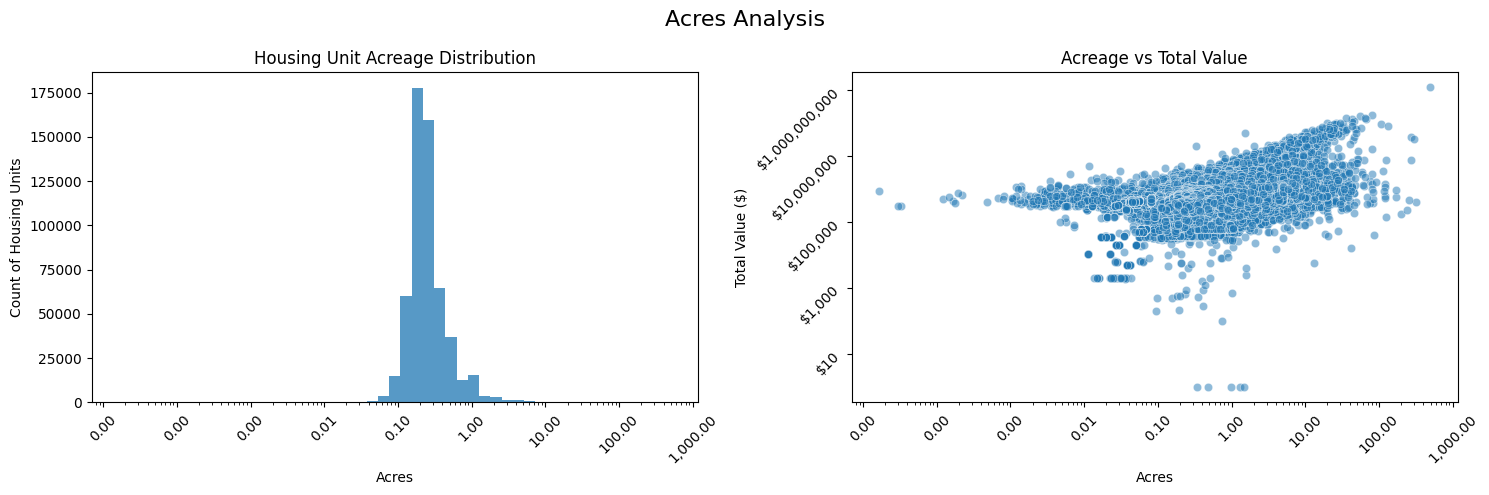

In [13]:
# Acres Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
min_acres = df.ACRES.min()
max_acres = df.ACRES.max()
bins = np.logspace(np.log10(min_acres), np.log10(max_acres), 50)

sns.histplot(df['ACRES'], bins=bins, ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_title('Housing Unit Acreage Distribution')
axs[0].set_xlabel('Acres')
axs[0].set_ylabel('Count of Housing Units')

# Format x-axis labels
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.2f}'))
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.scatterplot(data=df, x='ACRES', y='TOT_VALUE', alpha=0.5, ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Acreage vs Total Value')
axs[1].set_xlabel('Acres')
axs[1].set_ylabel('Total Value ($)')

# Format axis labels
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.2f}'))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='both', rotation=45)

fig.suptitle('Acres Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Approximate Built Year

Many of the housing units in this data sets were built between 2004-2006. However, some units are as old as the mid-1800's.

In [14]:
# Approximate Built Year - Independent Variable
print("Approximate Built Year Summary Statistics:")
df.APX_BLT_YR.value_counts()

Approximate Built Year Summary Statistics:


APX_BLT_YR
2006.0    14938
2005.0    13335
1978.0    12747
1999.0    12316
2004.0    12304
          ...  
1850.0        2
1858.0        2
1849.0        1
1848.0        1
1856.0        1
Name: count, Length: 175, dtype: int64

In [15]:
# Approximate Built Year - Independent Variable
print("Approximate Built Year Summary Statistics:")
df.APX_BLT_YR.describe()

Approximate Built Year Summary Statistics:


count    558696.000000
mean       1982.889008
std          27.877077
min        1848.000000
25%        1965.000000
50%        1990.000000
75%        2004.000000
max        2024.000000
Name: APX_BLT_YR, dtype: float64

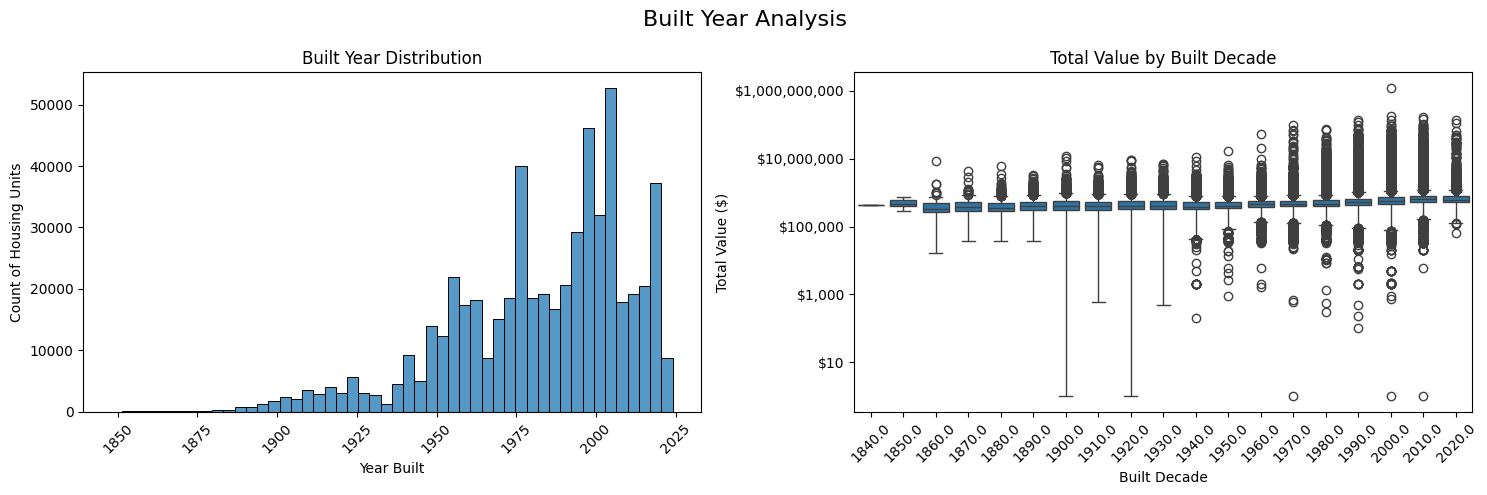

In [16]:
# Approximate Built Year Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
sns.histplot(df['APX_BLT_YR'], bins=50, ax=axs[0])
axs[0].set_title('Built Year Distribution')
axs[0].set_xlabel('Year Built')
axs[0].set_ylabel('Count of Housing Units')
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x)}'))
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.boxplot(data=df, x='BLT_DECADE', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by Built Decade')
axs[1].set_xlabel('Built Decade')
axs[1].set_ylabel('Total Value ($)')

# Format y-axis labels for currency
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle('Built Year Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Built Decade

A great majority of the housing units were built in the 1990s or later.

In [17]:
# Built Decade - Independent Variable
print("Built Decade Summary Statistics:")
df.BLT_DECADE.value_counts()

Built Decade Summary Statistics:


BLT_DECADE
2000.0    102634
1990.0     92196
1970.0     77076
2010.0     68102
1950.0     50938
1980.0     48834
1960.0     38088
1940.0     23341
2020.0     17476
1920.0     11696
1910.0      9639
1930.0      7356
1900.0      7094
1890.0      3032
1880.0       834
1870.0       239
1860.0       100
1850.0        19
1840.0         2
Name: count, dtype: int64

In [18]:
# Built Decade - Independent Variable
print("Built Decade Summary Statistics:")
df.BLT_DECADE.describe()

Built Decade Summary Statistics:


count    558696.000000
mean       1978.233941
std          27.891741
min        1840.000000
25%        1960.000000
50%        1990.000000
75%        2000.000000
max        2020.000000
Name: BLT_DECADE, dtype: float64

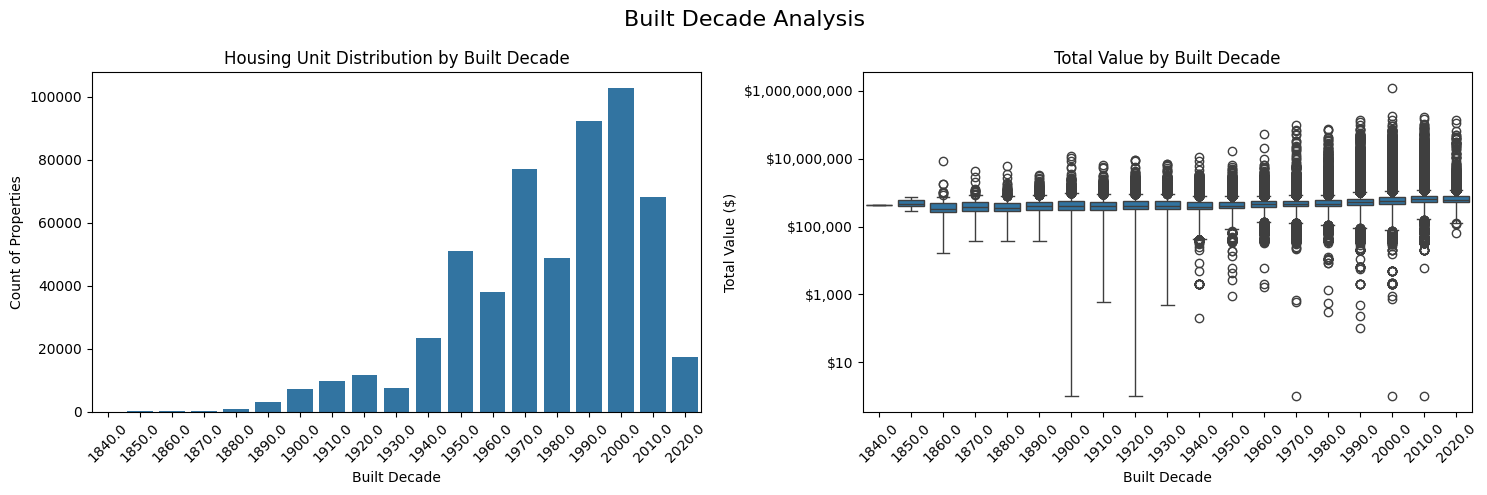

In [19]:
# Built Decade Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
decade_counts = df['BLT_DECADE'].value_counts().sort_index()
sns.barplot(x=decade_counts.index, y=decade_counts.values, ax=axs[0])
axs[0].set_title('Housing Unit Distribution by Built Decade')
axs[0].set_xlabel('Built Decade')
axs[0].set_ylabel('Count of Properties')
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.boxplot(data=df, x='BLT_DECADE', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by Built Decade')
axs[1].set_xlabel('Built Decade')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle('Built Decade Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### City

As expected, most of the housing units reside in Utah's most populated cities.

In [20]:
# City - Independent Variable
print("City Summary Statistics:")
df.CITY.value_counts()

City Summary Statistics:


CITY
Salt Lake City      38693
West Valley City    25974
West Jordan         25666
Sandy               23701
St. George          20582
                    ...  
Cedar Fort            147
Wendover              142
New Harmony           108
Vernon                 88
Fairfield              52
Name: count, Length: 101, dtype: int64

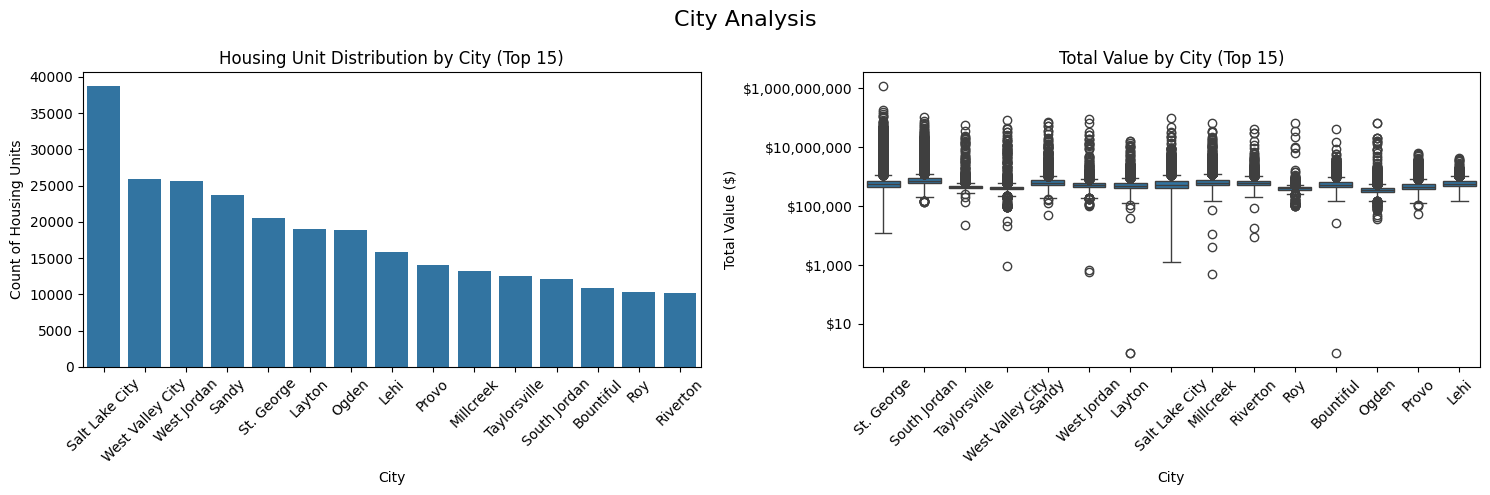

In [21]:
# City Analysis (Top 15 cities by count)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
city_counts = df['CITY'].value_counts().head(15)
sns.barplot(x=city_counts.index, y=city_counts.values, ax=axs[0])
axs[0].set_title('Housing Unit Distribution by City (Top 15)')
axs[0].set_xlabel('City')
axs[0].set_ylabel('Count of Housing Units')
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
top_15_cities = df['CITY'].value_counts().head(15).index
df_top_15 = df[df['CITY'].isin(top_15_cities)]
sns.boxplot(data=df_top_15, x='CITY', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by City (Top 15)')
axs[1].set_xlabel('City')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle('City Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### County

After data cleaning, only 8 of Utah's 29 counties exist in the data set. Unsurprisingly, they are some of Utah's most populated counties. Counties like Cache county are not represented.

In [22]:
# County - Independent Variable
print("County Summary Statistics:")
df.COUNTY.value_counts()

County Summary Statistics:


COUNTY
Salt Lake     236455
Utah          107505
Davis          84819
Weber          58486
Washington     46788
Tooele         16617
Box Elder       6839
Morgan          1187
Name: count, dtype: int64

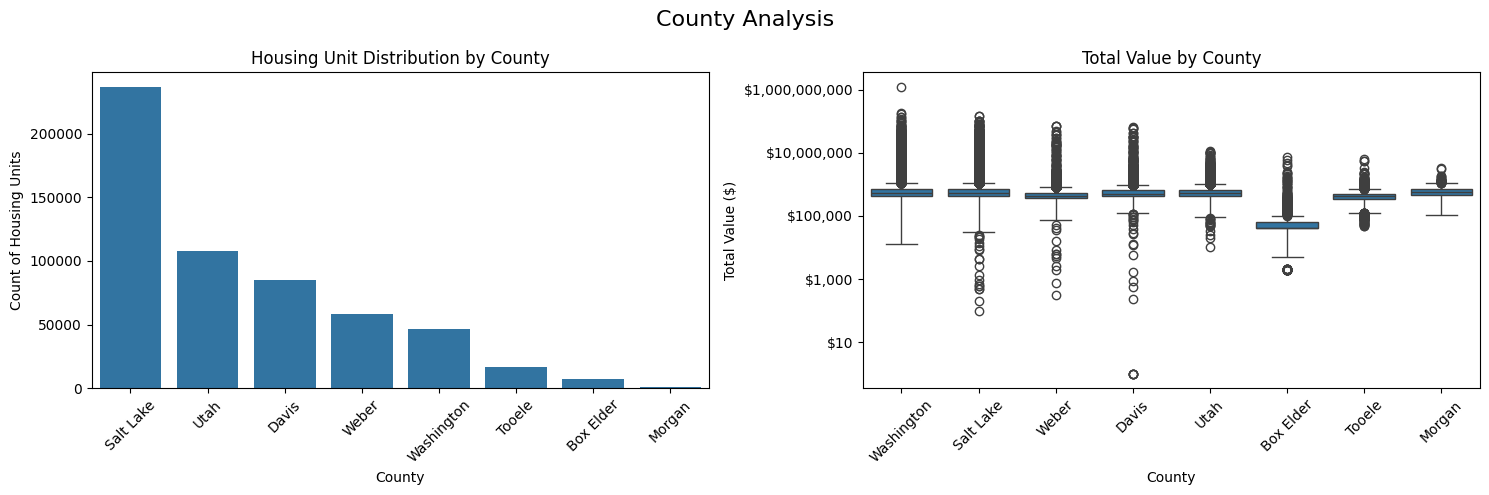

In [23]:
# County Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
county_counts = df['COUNTY'].value_counts()
sns.barplot(x=county_counts.index, y=county_counts.values, ax=axs[0])
axs[0].set_title('Housing Unit Distribution by County')
axs[0].set_xlabel('County')
axs[0].set_ylabel('Count of Housing Units')
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.boxplot(data=df, x='COUNTY', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by County')
axs[1].set_xlabel('County')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle('County Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Density in Unit Dwellings per Acre (DUA)

- Min: 0.000000
- Max: 60115.260000
- Mean: 5.084455
- Median: 4.400000

In [24]:
# Density in Unit Dwellings per Acre (DUA) - Independent Variable
print("Density in Unit Dwellings per Acre (DUA) Summary Statistics:")
df.DUA.describe()

Density in Unit Dwellings per Acre (DUA) Summary Statistics:


count    558696.000000
mean          5.084312
std         102.902757
min           0.000000
25%           3.240000
50%           4.400000
75%           5.510000
max       60115.260000
Name: DUA, dtype: float64

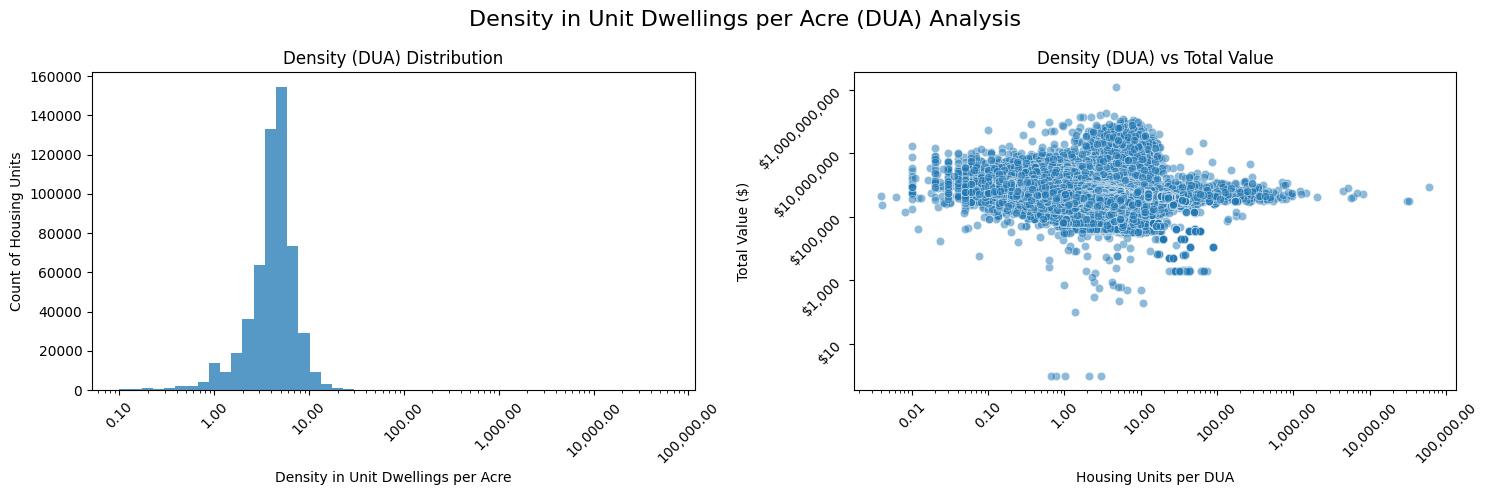

In [25]:
# Density (DUA) Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
min_dua = df.DUA.min()
max_dua = df.DUA.max()
bins = np.logspace(np.log10(max(min_dua, 0.1)), np.log10(max_dua), 50)

sns.histplot(df['DUA'], bins=bins, ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_title('Density (DUA) Distribution')
axs[0].set_xlabel('Density in Unit Dwellings per Acre')
axs[0].set_ylabel('Count of Housing Units')

# Format x-axis labels to show numbers with decimals
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.2f}'))
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.scatterplot(data=df, x='DUA', y='TOT_VALUE', alpha=0.5, ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Density (DUA) vs Total Value')
axs[1].set_xlabel('Housing Units per DUA')
axs[1].set_ylabel('Total Value ($)')

# Format axis labels
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.2f}'))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='both', rotation=45)

fig.suptitle('Density in Unit Dwellings per Acre (DUA) Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Is Owned Unit Group (OUG)

99.6% of the housing units are not an OUG.

In [26]:
# Is Owned Unit Group (OUG) - Independent Variable
print("Is Owned Unit Group (OUG) Summary Statistics:")
df.IS_OUG.value_counts()

Is Owned Unit Group (OUG) Summary Statistics:


IS_OUG
0.0    556545
1.0      2151
Name: count, dtype: int64

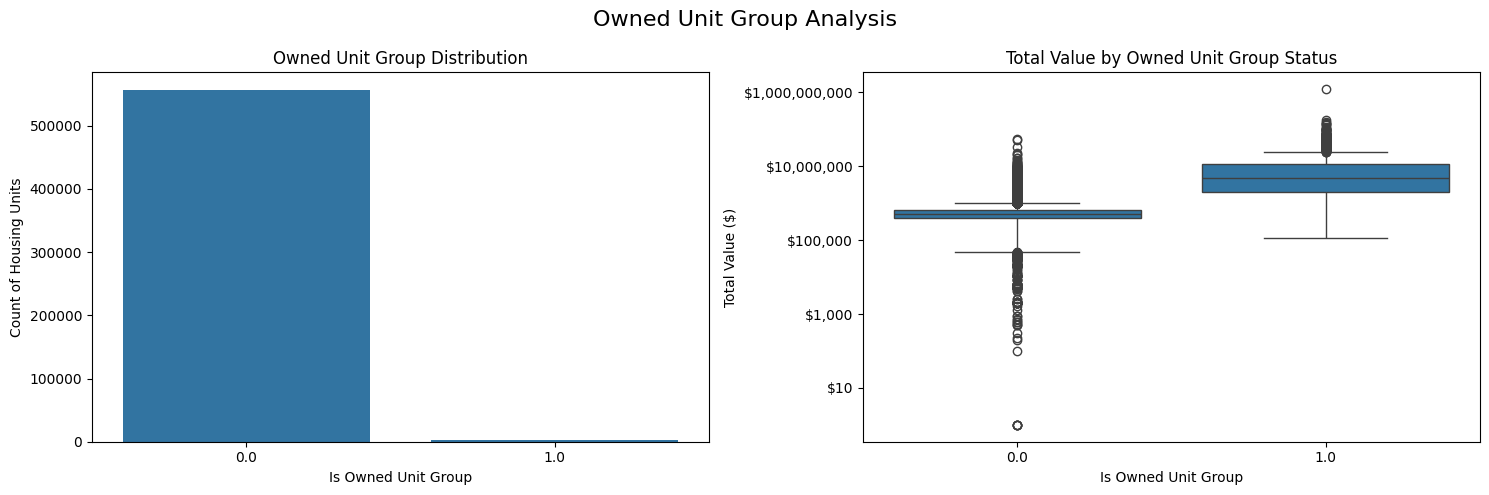

In [27]:
# IS_OUG Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
sns.countplot(data=df, x='IS_OUG', ax=axs[0])
axs[0].set_title('Owned Unit Group Distribution')
axs[0].set_xlabel('Is Owned Unit Group')
axs[0].set_ylabel('Count of Housing Units')

## Bivariate Analysis ##
sns.boxplot(data=df, x='IS_OUG', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by Owned Unit Group Status')
axs[1].set_xlabel('Is Owned Unit Group')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))

fig.suptitle('Owned Unit Group Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Subtype

99.3% of the housing units are simply single family homes.

In [28]:
# Subtype - Independent Variable
print("Subtype Summary Statistics:")
df.SUBTYPE.value_counts()

Subtype Summary Statistics:


SUBTYPE
single_family        554623
single_family_adu      1924
mobile_home_park       1691
townhome                458
Name: count, dtype: int64

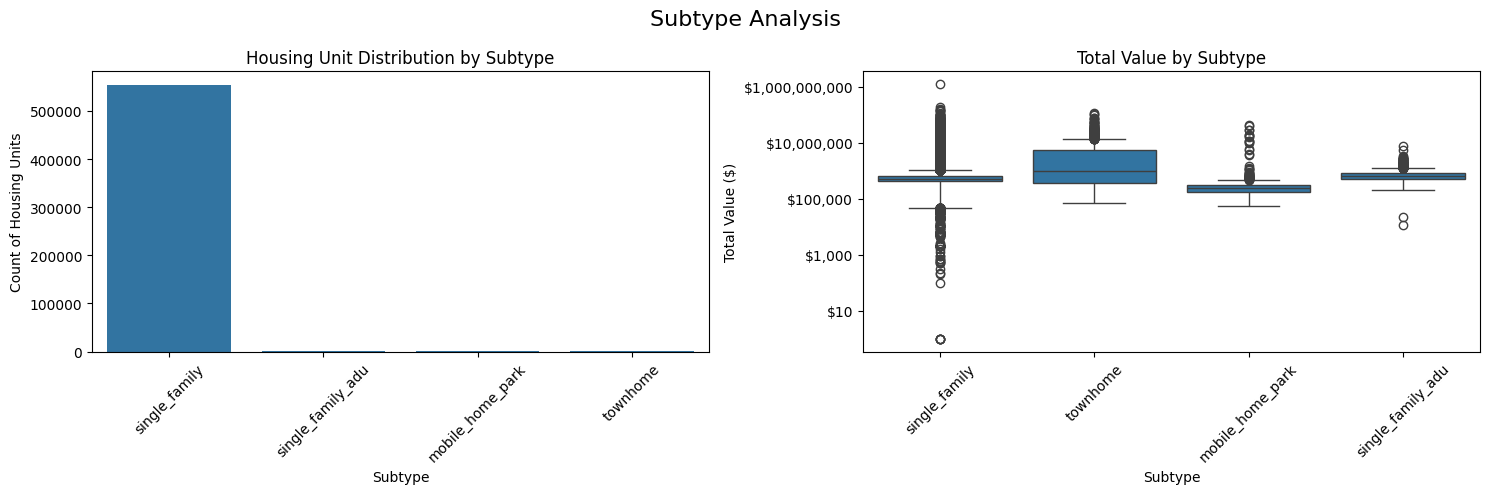

In [29]:
# Subtype Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
subtype_counts = df['SUBTYPE'].value_counts()
sns.barplot(x=subtype_counts.index, y=subtype_counts.values, ax=axs[0])
axs[0].set_title('Housing Unit Distribution by Subtype')
axs[0].set_xlabel('Subtype')
axs[0].set_ylabel('Count of Housing Units')
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.boxplot(data=df, x='SUBTYPE', y='TOT_VALUE', ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Total Value by Subtype')
axs[1].set_xlabel('Subtype')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='x', rotation=45)

fig.suptitle('Subtype Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Total Building Square Footage

- Min: 1
- Max: 4,106,589
- Mean: 2,603.778
- Median: 2,132

In [30]:
# Total Building Square Footage (TOT_BD_FT2) - Independent Variable
print("Total Building Square Footage (TOT_BD_FT2) Summary Statistics:")
df.TOT_BD_FT2.describe()

Total Building Square Footage (TOT_BD_FT2) Summary Statistics:


count    5.586960e+05
mean     2.603778e+03
std      7.312262e+03
min      1.000000e+00
25%      1.560000e+03
50%      2.132000e+03
75%      3.057000e+03
max      4.106589e+06
Name: TOT_BD_FT2, dtype: float64

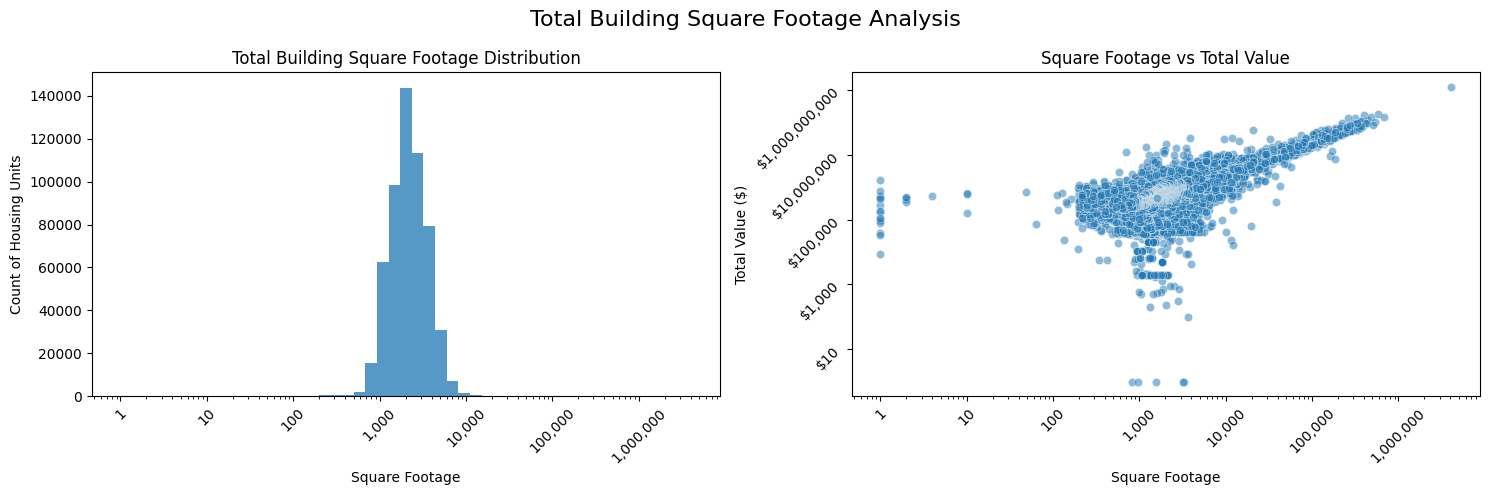

In [31]:
# Total Building Square Footage Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
min_sqft = df.TOT_BD_FT2.min()
max_sqft = df.TOT_BD_FT2.max()
bins = np.logspace(np.log10(min_sqft), np.log10(max_sqft), 50)

sns.histplot(df['TOT_BD_FT2'], bins=bins, ax=axs[0])
axs[0].set_xscale('log')
axs[0].set_title('Total Building Square Footage Distribution')
axs[0].set_xlabel('Square Footage')
axs[0].set_ylabel('Count of Housing Units')

# Format x-axis labels to show numbers with commas
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
axs[0].tick_params(axis='x', rotation=45)

## Bivariate Analysis ##
sns.scatterplot(data=df, x='TOT_BD_FT2', y='TOT_VALUE', alpha=0.5, ax=axs[1])
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_title('Square Footage vs Total Value')
axs[1].set_xlabel('Square Footage')
axs[1].set_ylabel('Total Value ($)')

# Format axis labels
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{x:,.0f}'))
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].tick_params(axis='both', rotation=45)

fig.suptitle('Total Building Square Footage Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#### Unit Count

- Min: 0.000000
- Max: 2312.000000
- Mean: 1.078162
- Median: 1.000000

In [32]:
# Unit Count - Independent Variable
print("Unit Count Summary Statistics:")
df.UNIT_COUNT.describe()

Unit Count Summary Statistics:


count    558696.000000
mean          1.078162
std           3.903092
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        2312.000000
Name: UNIT_COUNT, dtype: float64

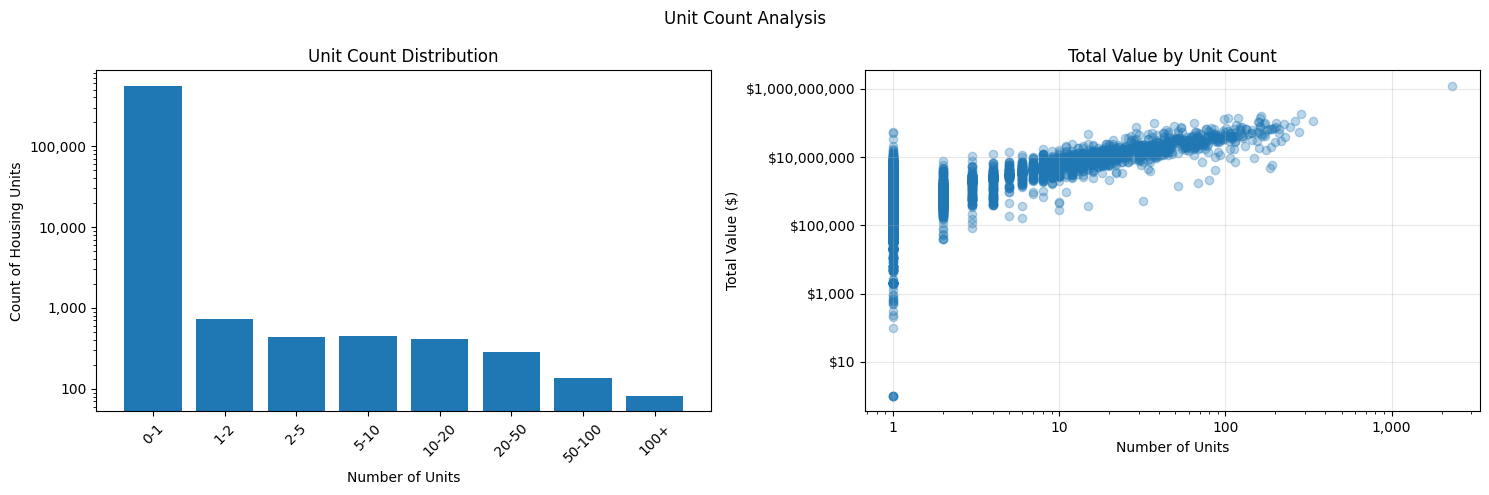

In [33]:
# Unit Count Analysis
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

## Univariate Analysis ##
# Create more meaningful bins for unit counts
bins = [0, 1, 2, 5, 10, 20, 50, 100, float('inf')]
labels = ['0-1', '1-2', '2-5', '5-10', '10-20', '20-50', '50-100', '100+']

# Create binned data as a separate series instead of adding to df
unit_range = pd.cut(df['UNIT_COUNT'], bins=bins, labels=labels)

# Plot histogram using value_counts
unit_counts = unit_range.value_counts().sort_index()
axs[0].bar(range(len(unit_counts)), unit_counts.values)
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels)
axs[0].set_title('Unit Count Distribution')
axs[0].set_xlabel('Number of Units')
axs[0].set_ylabel('Count of Housing Units')
axs[0].set_yscale('log')
axs[0].tick_params(axis='x', rotation=45)
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))

## Bivariate Analysis ##
# Create scatter plot
axs[1].scatter(df['UNIT_COUNT'], df['TOT_VALUE'], alpha=0.3)
axs[1].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_title('Total Value by Unit Count')
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Total Value ($)')
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'${x:,.0f}'))
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: f'{int(x):,}'))
axs[1].grid(True, alpha=0.3)

fig.suptitle('Unit Count Analysis')
plt.tight_layout()
plt.show()

### Outlier Treatment

In [34]:
# Log transform the values and remove outliers
log_values = np.log(df['TOT_VALUE'])
Q1 = log_values.quantile(0.25)
Q3 = log_values.quantile(0.75)
IQR = Q3 - Q1

lower_bound = np.exp(Q1 - 3.0 * IQR)
upper_bound = np.exp(Q3 + 3.0 * IQR)

# Print removal analysis
print(f"\nRemoval Analysis:")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")

# Identify outliers
outliers_low = df[df['TOT_VALUE'] < lower_bound]
outliers_high = df[df['TOT_VALUE'] > upper_bound]
print(f"Records below lower bound: {len(outliers_low)} ({len(outliers_low)/len(df)*100:.2f}%)")
print(f"Records above upper bound: {len(outliers_high)} ({len(outliers_high)/len(df)*100:.2f}%)")

# Create cleaned dataset
df = df[(df['TOT_VALUE'] >= lower_bound) & (df['TOT_VALUE'] <= upper_bound)]
print(f"\nCleaned dataset size: {len(df)}")


Removal Analysis:
Lower bound: $101541.46
Upper bound: $2651183.17
Records below lower bound: 6829 (1.22%)
Records above upper bound: 2766 (0.50%)

Cleaned dataset size: 549101


#### Feature Engineering and Standardization

In [35]:
# List of columns to encode
columns_to_encode = ['CITY', 'COUNTY', 'SUBTYPE']

# Create dummies for specified columns
df_encoded = pd.get_dummies(df, columns=columns_to_encode, drop_first=False)

In [36]:
df_encoded

,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY_Alpine,CITY_American Fork,...,COUNTY_Morgan,COUNTY_Salt Lake,COUNTY_Tooele,COUNTY_Utah,COUNTY_Washington,COUNTY_Weber,SUBTYPE_mobile_home_park,SUBTYPE_single_family,SUBTYPE_single_family_adu,SUBTYPE_townhome
18,1.0,80,7.991795,10.010267,12921.0,2131800.0,2022.0,2020.0,False,False,...,False,False,False,False,True,False,False,False,False,True
28,1.0,4,14.855026,0.269269,1920.0,594800.0,1980.0,1980.0,False,False,...,False,False,False,False,True,False,False,False,False,True
30,1.0,9,9.385018,0.958975,11264.0,2417600.0,2020.0,2020.0,False,False,...,False,False,False,False,True,False,False,False,False,True
45,1.0,68,8.560138,7.943797,11784.0,1762700.0,2022.0,2020.0,False,False,...,False,False,False,False,True,False,False,True,False,False
60,1.0,5,14.347598,0.348490,3952.0,963300.0,1980.0,1980.0,False,False,...,False,False,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558691,0.0,1,4.466728,0.223878,625.0,225106.0,1920.0,1920.0,False,False,...,True,False,False,False,False,False,False,True,False,False
558692,0.0,1,9.169656,0.109055,616.0,277474.0,1940.0,1940.0,False,False,...,True,False,False,False,False,False,False,True,False,False
558693,0.0,1,1.109902,0.900980,542.0,241476.0,1875.0,1870.0,False,False,...,True,False,False,False,False,False,False,True,False,False
558694,0.0,1,14.327806,0.069794,400.0,178119.0,1946.0,1940.0,False,False,...,True,False,False,False,False,False,False,True,False,False


In [37]:
# Only convert boolean columns to integers
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

# Convert float columns to int
flt_columns = ['APX_BLT_YR', 'BLT_DECADE', 'IS_OUG', 'TOT_BD_FT2', 'TOT_VALUE']
df_encoded[flt_columns] = df_encoded[flt_columns].astype(int)

In [38]:
df_encoded

,IS_OUG,UNIT_COUNT,DUA,ACRES,TOT_BD_FT2,TOT_VALUE,APX_BLT_YR,BLT_DECADE,CITY_Alpine,CITY_American Fork,...,COUNTY_Morgan,COUNTY_Salt Lake,COUNTY_Tooele,COUNTY_Utah,COUNTY_Washington,COUNTY_Weber,SUBTYPE_mobile_home_park,SUBTYPE_single_family,SUBTYPE_single_family_adu,SUBTYPE_townhome
18,1,80,7.991795,10.010267,12921,2131800,2022,2020,0,0,...,0,0,0,0,1,0,0,0,0,1
28,1,4,14.855026,0.269269,1920,594800,1980,1980,0,0,...,0,0,0,0,1,0,0,0,0,1
30,1,9,9.385018,0.958975,11264,2417600,2020,2020,0,0,...,0,0,0,0,1,0,0,0,0,1
45,1,68,8.560138,7.943797,11784,1762700,2022,2020,0,0,...,0,0,0,0,1,0,0,1,0,0
60,1,5,14.347598,0.348490,3952,963300,1980,1980,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558691,0,1,4.466728,0.223878,625,225106,1920,1920,0,0,...,1,0,0,0,0,0,0,1,0,0
558692,0,1,9.169656,0.109055,616,277474,1940,1940,0,0,...,1,0,0,0,0,0,0,1,0,0
558693,0,1,1.109902,0.900980,542,241476,1875,1870,0,0,...,1,0,0,0,0,0,0,1,0,0
558694,0,1,14.327806,0.069794,400,178119,1946,1940,0,0,...,1,0,0,0,0,0,0,1,0,0


In [39]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 549101 entries, 18 to 558695
Columns: 121 entries, IS_OUG to SUBTYPE_townhome
dtypes: float64(2), int32(118), int64(1)
memory usage: 263.9 MB


## Calculate Correlations

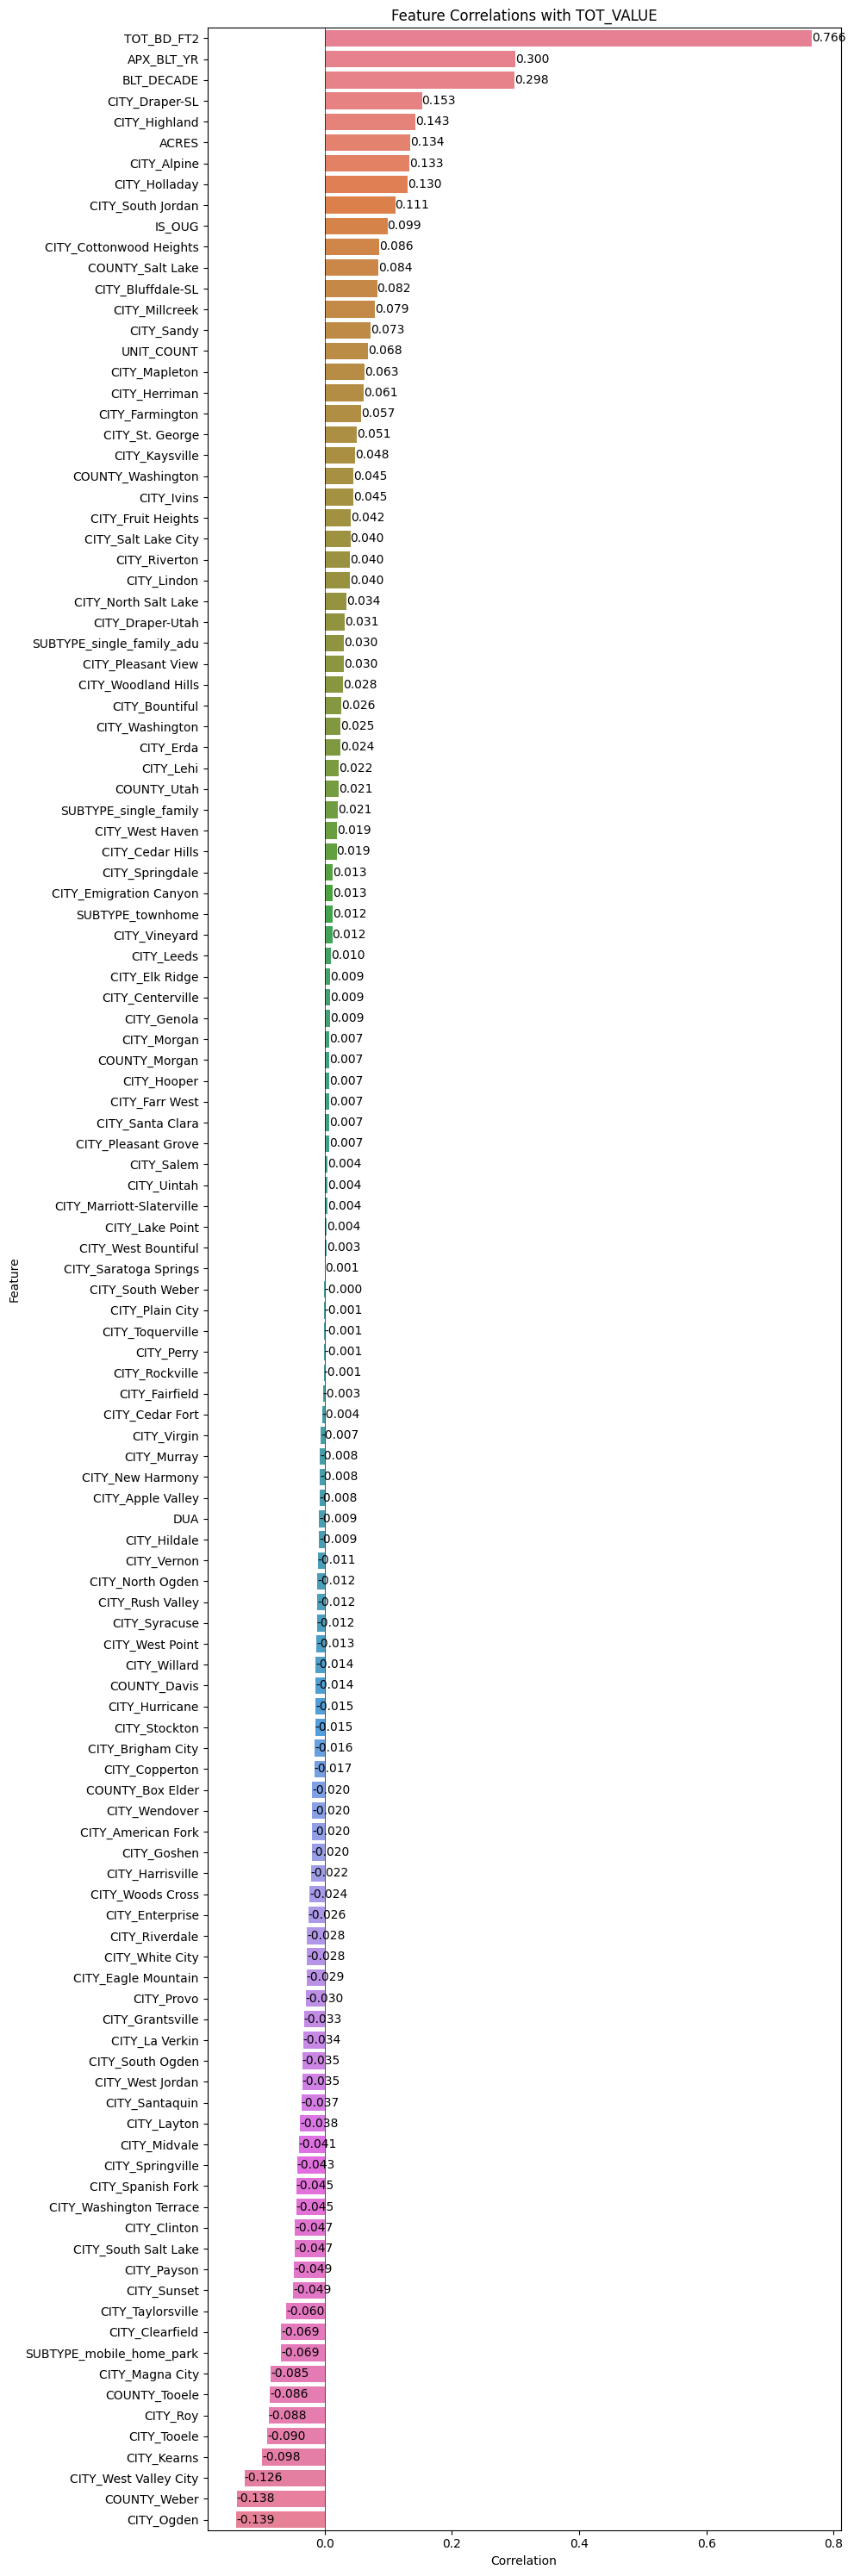

In [40]:
# Separate features and target
X = df_encoded.drop(['TOT_VALUE'], axis=1)
y = df_encoded['TOT_VALUE']

# Calculate correlations
correlations = pd.DataFrame({
    'Feature': X.columns,
    'Correlation': [X[col].corr(y) for col in X.columns]
}).sort_values('Correlation', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, max(8, len(X.columns)/4)))
sns.barplot(data=correlations, 
           x='Correlation', 
           y='Feature',
           hue='Feature',
           legend=False)

# Add a vertical line at x=0 to make it easier to distinguish positive/negative correlations
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)

# Customize the plot
plt.title('Feature Correlations with TOT_VALUE')
plt.xlabel('Correlation')

# Add value labels on the bars
for i, v in enumerate(correlations['Correlation']):
    plt.text(v, i, f'{v:.3f}', va='center')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Scale the Data

In [41]:
# Initialize scaler
scaler = StandardScaler()

# Scale all features
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

## Split the Data

In [42]:
# Set seed for reproducibility
SEED = 1

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=0.8,
    test_size=0.2,
    random_state=SEED
)

# Recombine features and target for each split into complete datasets
mod_train = pd.concat([X_train, y_train], axis=1)
mod_test = pd.concat([X_test, y_test], axis=1)

# Verify split sizes
print("Training set shape:", mod_train.shape)
print("Test set shape:", mod_test.shape)


Training set shape: (533269, 121)
Test set shape: (198017, 121)


## Initial Model

In [43]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1,)
rfr.fit(X_train, y_train)

# Make predictions
y_pred = rfr.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2:.3f}\n")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.3f}\n")

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.3f}")

R-squared Score: 0.842

Mean Squared Error: 10186082188.194
Root Mean Squared Error: 100926.122

Mean Absolute Error: 55948.001


## Hyperparameter Tuning

In [1]:
# Combine X_train and y_train into a single DataFrame to preserve index alignment
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
train_data = pd.concat([X_train, y_train], axis=1)

# Sample a fraction of the combined training data
sample_fraction = 0.05
sampled_data = train_data.sample(frac=sample_fraction, random_state=SEED)

# Separate the sampled features and target
X_train_sampled = sampled_data.drop(columns=y_train.name)
y_train_sampled = sampled_data[y_train.name]

# Verify the sampled sizes
print(f"Sampled training set shape: {X_train_sampled.shape}")

# Define parameters for hyperparameter tuning
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

# Set up grid search with 3-fold cross validation and r2 as the scoring metric
grid = GridSearchCV(
    rfr, 
    param_grid, 
    cv=2, 
    scoring='r2', 
    n_jobs=-1
)

# Perform the actual grid search
grid.fit(X_train_sampled, y_train_sampled)

# Print best parameters and score
print("\nBest parameters:", grid.best_params_)
print("Best R-Squared:", grid.best_score_)

NameError: name 'X_train' is not defined

## Final Model Predictions and Scoring

In [45]:
# Get the best model from grid search
best_rf = grid.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared Score: {r2:.3f}\n")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.3f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse:.3f}\n")

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.3f}")

R-squared Score: 0.805

Mean Squared Error: 12540528306.686
Root Mean Squared Error: 111984.500

Mean Absolute Error: 62548.030
